# initial expected loss check:
at initialization, we expect a loss value stands for uniform distribution, but not some one prefer another one
eg, we have 27 characters, we want prob = 1/27
so, loss = -log(1/27) = 3.2958

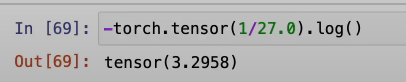

# this is a template for creating table, not relevant to the tut  : )


| Header 1 | Header 2 | Header 3 |
|----------|----------|----------|
| Row 1    | Data 1   | Data 2   |
| Row 2    | Data 3   | Data 4   |


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))

32033


In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 3
def build_dataset(words):
    X, Y =[], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
n_embd = 10
n_hidden = 200

g =torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, W2, b1, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [7]:
max_steps = 200000
bathch_size = 32
lossi = []
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (bathch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i: 7d}/{max_steps: 7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())


      0/ 200000:  24.6599
  10000/ 200000:  2.2034
  20000/ 200000:  2.2184
  30000/ 200000:  1.9518
  40000/ 200000:  2.3579
  50000/ 200000:  2.2594
  60000/ 200000:  2.2820
  70000/ 200000:  2.8396
  80000/ 200000:  2.6124
  90000/ 200000:  2.2631
 100000/ 200000:  2.3080
 110000/ 200000:  1.9569
 120000/ 200000:  2.1685
 130000/ 200000:  2.1063
 140000/ 200000:  1.8393
 150000/ 200000:  2.3407
 160000/ 200000:  2.0962
 170000/ 200000:  1.7805
 180000/ 200000:  1.9569
 190000/ 200000:  2.2122


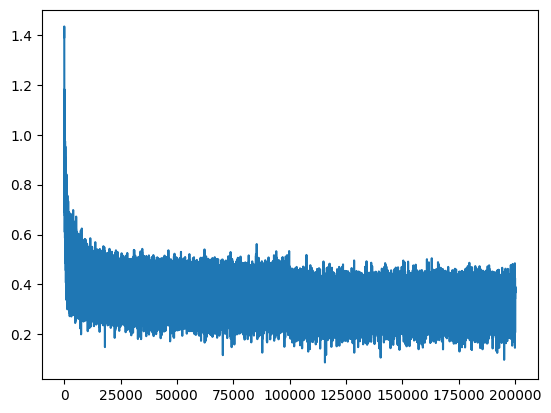

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.107064962387085
val 2.1564579010009766


In [11]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1)@W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mona.
mayah.
seel.
nihayla.
rethrelendraegen.
chedielin.
shyonelle.
elissopharleite.
malara.
noshubergihamiest.
jair.
jennox.
teron.
uszayven.
kylene.
els.
kaysh.
sanyah.
halisa.
yansus.
